In [78]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import scipy as scp
from scipy.integrate import trapezoid
import numpy as np
import awkward as ak
import pybaselines

In [80]:
FILE_PATH = "../Dati/Run_chall_ortho_Data_5_10_2024_Ascii_0001.root" #Relative file path
file = uproot.open(FILE_PATH)
file["tree"].show()

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
ev                   | int32_t                  | AsDtype('>i4')
nch                  | int32_t                  | AsDtype('>i4')
ch                   | int32_t[]                | AsJagged(AsDtype('>i4'))
base                 | float[]                  | AsJagged(AsDtype('>f4'))
amp                  | float[]                  | AsJagged(AsDtype('>f4'))
charge               | float[]                  | AsJagged(AsDtype('>f4'))
letime               | float[]                  | AsJagged(AsDtype('>f4'))
tetime               | float[]                  | AsJagged(AsDtype('>f4'))
pshape               | float[][1024]            | AsJagged(AsDtype("('>f4', (...


In [81]:
print(type(file["tree"]["base"].array()))
bl=file["tree"]["base"].array()
print(ak.num(bl))
#bl = bl[:-1]
print(np.unique(ak.num(bl)))
#l'ultimo array aveva una forma diversa, quindi l'ho tagliato altrimenti faceva casini

nch=file["tree"]["ch"].array()
print(nch)

<class 'awkward.highlevel.Array'>
[16, 16, 16, 16, 16, 16, 16, 16, 16, ..., 16, 16, 16, 16, 16, 16, 16, 16, 16]
[16]
[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], ..., [0, 1, ..., 15]]


In [82]:
baselines = np.array(file["tree"]["base"])[1:-1] 
charges = np.array(file["tree"]["charge"])[1:-1]
amp = np.array(file["tree"]["amp"])[1:-1]
lead_edge = np.array(file["tree"]["letime"])[1:-1]
t_edge = np.array(file["tree"]["tetime"])[1:-1]
channel= np.array(file["tree"]["ch"])[1:-1]
waveform = np.array(file["tree"]["pshape"])[1:-1]


In [83]:
print(amp.shape)
print(charges.shape)
print(len(amp))

(5598,)
(5598,)
5598


In [84]:
len(np.where(amp[0]>-1.2)[0])==16

True

In [85]:
print(channel)

[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)
 ...
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32)                                                     ]


In [86]:

mask=[len(np.where(amp[i]>-1.2)[0])==16 for i in range(len(amp))]
print(mask)
baselines=baselines[mask]
charges=charges[mask]
amp=amp[mask]
lead_edge=lead_edge[mask]
t_edge=t_edge[mask]
channel=channel[mask]
waveform=waveform[mask]

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, False, False, True, True, True, True, True, True, True, True, False, True, True, False, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, True, True, True, False, False, True, True, False, True, True, True, True, False, True, True, False, True, True, True, True, True, True, True, True, True, True, False, True, False, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, True, True, True, False, True, True, False, True, False, True, True, True, True, True, True, False, True, True, True, True, True, False, True, True, False, True, True, True, True, Tru

In [87]:
print(len(amp))
Nev=len(amp)

4594


(4594,)
channel: 0 baseline: -0.000229 charge 0.898 lead_edge 344.295 trailing_edge 344.044
channel: 1 baseline: 0.000762 charge -2.78 lead_edge 231.141 trailing_edge 229.778
channel: 2 baseline: 0.000572 charge -3.003 lead_edge 402.412 trailing_edge 399.657
channel: 3 baseline: -7.6e-05 charge -0.303 lead_edge 165.419 trailing_edge 164.744
channel: 4 baseline: 0.00061 charge -4.004 lead_edge 463.754 trailing_edge 460.599
channel: 5 baseline: 0.000114 charge 0.177 lead_edge 465.609 trailing_edge 464.702
channel: 6 baseline: -0.000343 charge 1.813 lead_edge 341.86 trailing_edge 337.659
channel: 7 baseline: 0.000305 charge -2.316 lead_edge 440.94 trailing_edge 439.3
channel: 8 baseline: -0.000114 charge 3.237 lead_edge 299.689 trailing_edge 298.7
channel: 9 baseline: 0.0 charge -1.533 lead_edge 31.969 trailing_edge 30.544
channel: 10 baseline: -0.008082 charge -197.824 lead_edge 272.651 trailing_edge -0.003
channel: 11 baseline: 0.000229 charge -3.312 lead_edge 433.542 trailing_edge 429.

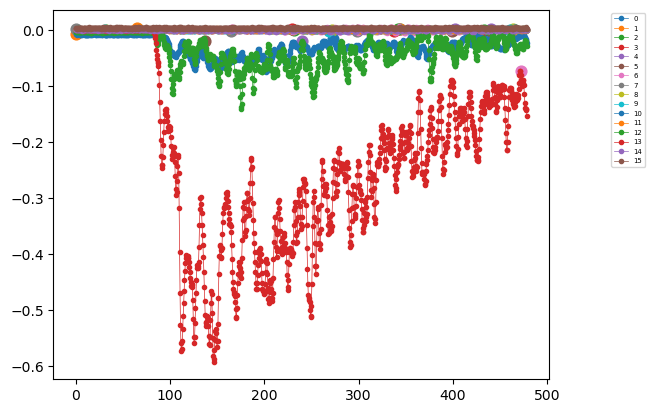

In [88]:
print(waveform.shape)
event=56
list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
#list=[1,2,7,12]
sampling=0.468
for channel in list:
    time=np.arange(1024)
    plt.plot(time*sampling, waveform[event][channel], '.-', label='{}'.format(channel), linewidth=0.5)
    print("channel:", channel, "baseline:",  baselines[event][channel],"charge", charges[event][channel], "lead_edge", lead_edge[event][channel], "trailing_edge", t_edge[event][channel] )
    t1=lead_edge[event][channel]
    t2=t_edge[event][channel]
    #print(t1,t2)
    plt.scatter( t1, waveform[event][channel][int(t1/sampling)],s=60   )
    plt.scatter( t2, waveform[event][channel][int(t2/sampling)],s=60  )
    #plt.xlim(400,600)
    #plt.ylim(-0.01, 0.1)

plt.legend(fontsize=5, loc='upper right', bbox_to_anchor=(1.2, 1))

In [90]:
###pulizia
list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
true_charges=[]
true_amps=[]
true_channels=[]
true_waveforms=[]
true_ledge=[]
for ev in range(Nev):
    interesting_channels=np.where(charges[ev]<-50)[0] #canali che hanno visto qualcosa
    true_channels.append(interesting_channels.tolist())
    true_charges.append([charges[ev][ch] for ch in interesting_channels])
    true_amps.append([amp[ev][ch] for ch in interesting_channels])
    true_waveforms.append([waveform[ev][ch] for ch in interesting_channels])
    true_ledge.append([lead_edge[ev][ch] for ch in interesting_channels])


print(true_channels)
print(true_charges)





[[2, 3, 9], [7, 9, 11], [3, 11, 13], [4, 9, 12], [2, 7, 9], [2, 4, 12], [2, 4, 12], [2, 9, 14], [2, 11, 14], [2, 5, 7], [3, 8, 9], [2, 4, 13], [0, 2, 4], [4, 6, 14], [5, 6, 7], [7, 9, 13], [0, 1, 2, 9], [7, 11, 13], [4, 6, 11], [3, 4, 7], [4, 6, 13], [7, 8, 11], [2, 4, 12], [2, 4, 8, 12], [2, 5, 12], [2, 4, 12], [0, 12, 15], [2, 4, 6], [2, 3, 13], [3, 4, 5, 12], [2, 5, 12], [1, 7, 12], [2, 3, 12], [0, 1, 9], [4, 9, 11], [2, 4, 9], [4, 7, 11], [0, 1, 12], [7, 9, 11], [2, 7, 9], [10, 12, 15], [3, 7, 9], [1, 2, 4], [7, 9, 14], [4, 10, 12], [3, 9, 11], [2, 3, 7], [7, 11, 13], [0, 1, 3], [3, 9, 13], [7, 10, 14], [4, 9, 12], [11, 13, 14], [11, 13, 14], [4, 7, 9], [2, 8, 9], [10, 12, 13], [0, 1, 4], [2, 4, 13], [9, 10, 13], [0, 1, 2, 7], [7, 8, 9], [3, 9, 13], [3, 6, 7], [1, 2, 12], [0, 2, 15], [2, 9, 11], [3, 7, 9], [3, 4, 15], [0, 2, 10], [3, 7, 10], [2, 9, 13], [4, 6, 9, 12, 15], [0, 1, 5], [2, 4, 6], [2, 3, 8], [2, 11, 13], [2, 5, 13], [1, 2, 11], [4, 6, 11], [2, 11, 13], [7, 9, 12], [2, 

In [91]:
#eventi con 3 gamma
n_photons=[len(true_channels[i]) for i in range(Nev)]
n_photons=np.array(n_photons)
three_gamma_events=np.where(n_photons == 4)[0] #eventi con 4 fotoni totali (ortopositronio?)
print(three_gamma_events)
four_gamma_events=np.where(n_photons == 5)[0]
print(four_gamma_events)

[  16   23   29   60   86  149  158  176  211  213  214  225  235  236
  253  263  275  278  292  367  378  387  410  412  434  442  449  518
  575  594  598  620  627  705  738  769  774  781  792  811  831  842
  849  852  886  895  917  932  963 1005 1035 1049 1055 1056 1058 1074
 1086 1102 1118 1119 1159 1164 1191 1201 1223 1242 1257 1295 1306 1313
 1322 1327 1349 1359 1384 1386 1398 1407 1417 1418 1439 1444 1497 1513
 1516 1536 1591 1594 1617 1621 1635 1668 1676 1686 1688 1693 1729 1758
 1770 1774 1799 1829 1848 1857 1862 1901 1903 1931 1933 1958 2013 2018
 2034 2093 2105 2124 2127 2139 2154 2232 2276 2321 2324 2359 2404 2472
 2478 2551 2554 2564 2569 2573 2586 2592 2598 2611 2613 2629 2631 2655
 2775 2818 2845 2846 2891 2899 2978 2983 3000 3045 3076 3120 3140 3155
 3164 3197 3201 3244 3264 3267 3269 3279 3287 3340 3372 3381 3406 3444
 3473 3538 3559 3568 3585 3599 3612 3641 3690 3704 3709 3736 3753 3758
 3780 3784 3814 3827 3844 3873 3907 3942 3990 4048 4096 4100 4102 4113
 4195 

channel: 0 baseline: -0.000114 charge -256.524 lead_edge 322.876 trailing_edge -0.009
channel: 1 baseline: 0.000648 charge -1113.727 lead_edge 457.433 trailing_edge 96.51
channel: 2 baseline: -0.000152 charge -3722.404 lead_edge 471.936 trailing_edge 88.984
channel: 9 baseline: -3.8e-05 charge -1699.649 lead_edge -0.002 trailing_edge -0.002
channel: 2 baseline: 0.000419 charge -1242.338 lead_edge 375.188 trailing_edge -0.014
channel: 4 baseline: 0.000419 charge -276.629 lead_edge 177.899 trailing_edge 0.013
channel: 8 baseline: -3.8e-05 charge -146.279 lead_edge 257.818 trailing_edge 204.753
channel: 12 baseline: -0.004079 charge -1462.806 lead_edge 396.138 trailing_edge -0.005
channel: 3 baseline: 0.000267 charge -477.69 lead_edge 251.145 trailing_edge -0.006
channel: 4 baseline: -0.006977 charge -203.063 lead_edge 103.568 trailing_edge 21.123
channel: 5 baseline: 0.000305 charge -1989.816 lead_edge 427.255 trailing_edge 76.551
channel: 12 baseline: -0.031301 charge -211.808 lead_edge

/var/folders/17/9cj0cbps58xbmrl2zpj6hv2h0000gn/T/ipykernel_50801/2728032489.py:36: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


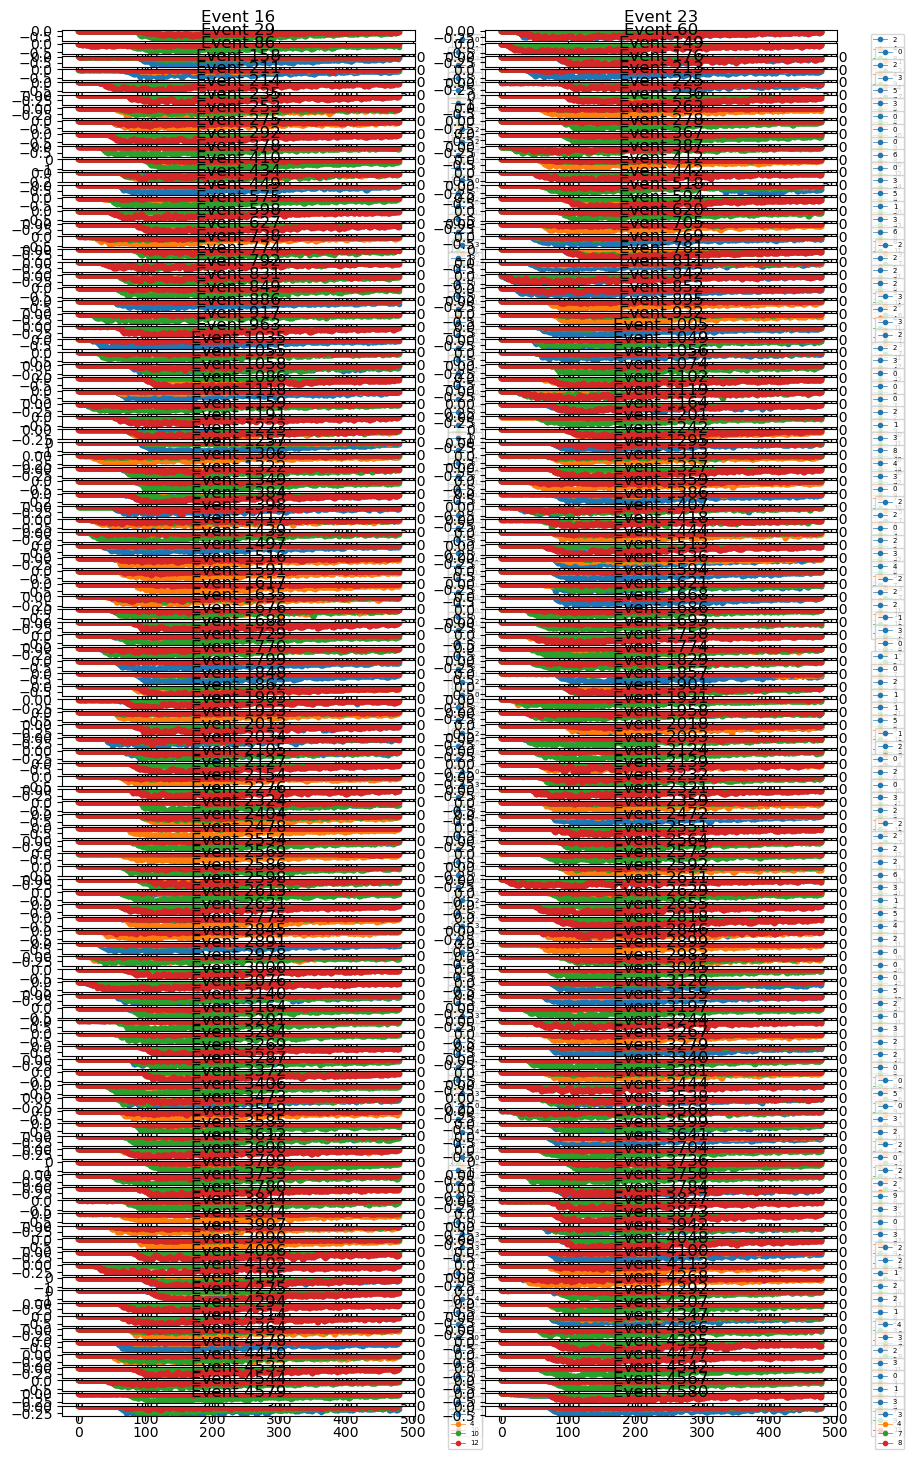

In [92]:
#plot degli eventi di papabile ortopositronio

# Define the number of events to plot
num_events = len(three_gamma_events)

# Define the layout of subplots
num_cols = 2  # Number of columns of subplots
num_rows = (num_events + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Create a new figure and axes for each subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 18))

# Flatten the axes array if it's multidimensional
axes = axes.flatten()

# Loop over each event in the event list
for i, event in enumerate(three_gamma_events):
    # Retrieve the list of channels for the current event
    list = true_channels[event]
    
    # Plot waveforms for each channel in the event
    for channel in list:
        time = np.arange(1024)  # Create an array of time samples
        axes[i].plot(time * sampling, waveform[event][channel], '.-', label='{}'.format(channel), linewidth=0.5)
        print("channel:", channel, "baseline:", baselines[event][channel], "charge", charges[event][channel], "lead_edge", lead_edge[event][channel], "trailing_edge", t_edge[event][channel])
        t1 = lead_edge[event][channel]
        t2 = t_edge[event][channel]
        #axes[i].scatter(t1, waveform[event][channel][int(t1 / sampling)], s=60)
        #axes[i].scatter(t2, waveform[event][channel][int(t2 / sampling)], s=60)
    
    # Add legend to the subplot
    axes[i].legend(fontsize=5, loc='upper right', bbox_to_anchor=(1.2, 1))
    axes[i].set_title(f'Event {event}')  # Set title for the subplot

# Adjust layout and display the plot
plt.tight_layout()
plt.show()



In [93]:
print([true_charges[ev] for ev in three_gamma_events])

[[-256.524, -1113.727, -3722.404, -1699.649], [-1242.338, -276.629, -146.279, -1462.806], [-477.69, -203.063, -1989.816, -211.808], [-137.162, -227.657, -561.963, -2497.333], [-3149.426, -366.083, -929.916, -156.237], [-1349.638, -222.704, -104.68, -1556.447], [-1931.356, -460.886, -172.938, -232.13], [-2129.809, -150.712, -54.531, -321.156], [-565.938, -59.061, -459.868, -2250.922], [-874.19, -435.113, -158.759, -827.232], [-59.924, -563.684, -736.359, -1589.352], [-693.754, -2124.209, -160.309, -5227.787], [-162.242, -1275.483, -1007.239, -278.27], [-154.384, -3102.777, -247.87, -386.251], [-1226.46, -2323.286, -593.129, -1215.605], [-109.656, -209.904, -1063.823, -72.873], [-219.415, -266.631, -576.239, -2388.918], [-1682.593, -614.285, -3137.008, -571.205], [-99.841, -59.432, -3024.069, -61.995], [-380.096, -139.85, -1299.111, -720.716], [-213.027, -2563.984, -4507.197, -729.381], [-208.571, -3154.104, -661.398, -594.627], [-63.47, -716.821, -752.488, -475.333], [-170.072, -855.687

[3.042, 6.318000000000001, 2.1060000000000016, 0.7020000000000053, 1.1700000000000088, 4.68, 10.763999999999996, 1.6379999999999981, 2.3400000000000034, 4.212, 3.7439999999999998, 5.3820000000000014, 4.68, 27.144000000000005, 6.317999999999998, 0.936000000000007, 3.2760000000000105, 4.212, 7.176000000000002, 4.679999999999996, 6.785999999999994, 2.3400000000000034, 3.744000000000007, 3.276, 6.318000000000001, 0.46799999999999997, 3.743999999999996, 6.785999999999994, 2.1059999999999945, 2.5740000000000007, 61.77600000000001, 3.7439999999999927, 5.850000000000001, 4.914000000000001, 7.253999999999998, 1.8720000000000034, 1.6379999999999981, 1.6380000000000017, 1.1700000000000017, 1.1699999999999946, 5.381999999999991, 2.573999999999998, 4.212000000000003, 2.34, 6.552, 3.0420000000000016, 5.147999999999996, 2.105999999999998, 1.6379999999999981, 5.148000000000003, 1.8720000000000034, 3.977999999999998, 7.020000000000003, 2.573999999999991, 2.34, 0.23400000000000176, 2.3400000000000034, 0

(array([ 73., 122.,  61.,  30.,   7.,   7.,   1.,   1.,   0.,   1.,   0.,
          1.,   0.,   1.,   0.,   0.,   1.,   2.,   1.,   0.,   0.,   0.,
          0.,   1.,   0.,   1.,   0.,   1.,   0.,   1.,   0.,   1.,   0.,
          0.,   1.]),
 array([ 0.        ,  1.95222857,  3.90445714,  5.85668571,  7.80891429,
         9.76114286, 11.71337143, 13.6656    , 15.61782857, 17.57005714,
        19.52228571, 21.47451429, 23.42674286, 25.37897143, 27.3312    ,
        29.28342857, 31.23565714, 33.18788571, 35.14011429, 37.09234286,
        39.04457143, 40.9968    , 42.94902857, 44.90125714, 46.85348571,
        48.80571429, 50.75794286, 52.71017143, 54.6624    , 56.61462857,
        58.56685714, 60.51908571, 62.47131429, 64.42354286, 66.37577143,
        68.328     ]),
 <BarContainer object of 35 artists>)

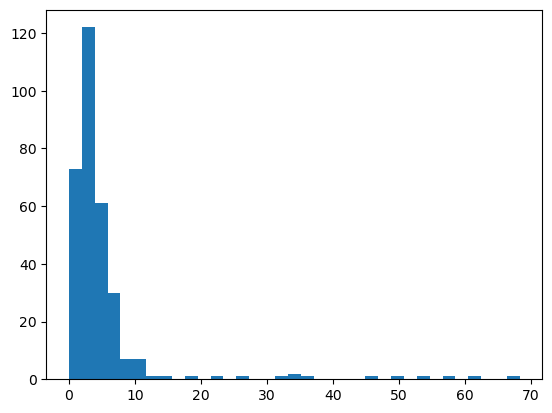

In [98]:
#per ogni evento 
def arrival_time(waveform, treshold):
    index=np.where(waveform <=treshold)[0][0]
    t_arr=index*sampling
    return t_arr


good_t_arr=[]
time_diff=[]

treshold=-0.020 #soglia fissa
for ev in range(Nev):
    #trovo il leading edge del gamma da 1200
    index_1200=true_charges[ev].index(max(true_charges[ev]))
    ch_1200=true_channels[ev][index_1200] #trova il canale che ha visto la carica più alta
    t_arr=[arrival_time(true_waveforms[ev][ch], treshold) for ch in range(len(true_channels[ev]))] #calcolo tempi di arrivo dei segnali
    ev_is_good=[t_arr[i] >= t_arr[index_1200] and t_arr[index_1200]!=0  for i in range(len(true_channels[ev]))]
    if(all(ev_is_good)):
        good_t_arr.append(t_arr)
        t_diff=[t_arr[i] - t_arr[index_1200] for i in range(len(t_arr))]
        t_diff.pop(index_1200)
        time_diff.append(t_diff)

        #print('Channels:', true_channels[ev])
        #print('ch 1200:', ch_1200)
        #print('T_arr:', t_arr)


#print(time_diff)
mean_time_diff=[np.mean(np.array(times)) for times in time_diff]
print(mean_time_diff)

plt.hist(mean_time_diff, bins=35)


